In [82]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
from torchvision import transforms
from torchvision.utils import save_image
from torchvision.datasets import MNIST
import numpy as np
import os
import time
import pandas as pd

if not os.path.exists('./dc_img'):
    os.mkdir('./dc_img')

In [46]:
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x

In [50]:
class MNIST_Dataset(Dataset):
    
    def __init__(self, dataset, *args, **kwargs):
        
        super(MNIST_Dataset, self, *args, **kwargs).__init__()
        self.dataset=dataset
    
    def __getitem__(self, idx):
        tmp=self.dataset[idx]
        return [*tmp, idx]
    
    def __len__(self):
        return len(self.dataset)

# Training of the Auto Encoder

In [47]:
class Reshape(nn.Module):
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)

In [8]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=3, padding=1),  # b, 16, 10, 10
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),  # b, 16, 5, 5
            nn.Conv2d(16, 8, 3, stride=2, padding=1),  # b, 8, 3, 3
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=1),  # b, 8, 2, 2
            nn.Flatten(),
            nn.Linear(8*2*2, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(True),
            nn.Linear(32, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(True),
            nn.Linear(16,10),
            nn.BatchNorm1d(10),
            nn.Softmax(1),
            
        )
        self.decoder = nn.Sequential(
            nn.Linear(10, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(True),
            nn.Linear(16,32),
            nn.BatchNorm1d(32),
            nn.ReLU(True),
            Reshape(-1,8,2,2),
            nn.ConvTranspose2d(8, 16, 3, stride=2),  # b, 16, 5, 5
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 5, stride=3, padding=1),  # b, 8, 15, 15
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 2, stride=2, padding=1),  # b, 1, 28, 28
            nn.Tanh(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [65]:
def loss_fun_AutoEncoder(targets, predicted):
    loss = nn.MSELoss()
    return loss(predicted, targets)
    # return nn.BCEWithLogitsLoss()(outputs, targets)

In [67]:
def train_loop_fun_AutoEncoder(data_loader, model, optimizer, device, scheduler=None):
    model.train()
    t0 = time.time()
    losses = []
    for batch_idx, (data, targets, data_idx) in enumerate(data_loader):
                
        optimizer.zero_grad()
        outputs = model(data)
        
        loss = loss_fun_AutoEncoder(outputs, data)
        loss.backward()        
        model.float()
        optimizer.step()
        
        if scheduler:
            scheduler.step()
        losses.append(loss.item())
        if batch_idx % 150 == 0:
            print(
                f"___ batch index = {batch_idx} / {len(data_loader)} ({100*batch_idx / len(data_loader):.2f}%), loss = {np.mean(losses[-10:]):.4f}, time = {time.time()-t0:.2f} secondes ___")
            t0 = time.time()
    return losses

In [71]:
def eval_loop_fun_AutoEncoder(data_loader, model, device):
    model.eval()
    fin_targets = []
    fin_outputs = []
    losses = []
    for batch_idx, (data, targets, data_idx) in enumerate(data_loader):

        
        with torch.no_grad():
            outputs = model(data)
            loss = loss_fun_AutoEncoder(outputs, data)
            losses.append(loss.item())

        fin_targets.append(targets.cpu().detach().numpy())
        fin_outputs.append(outputs.cpu().detach().numpy())
    return np.concatenate(fin_outputs), np.concatenate(fin_targets), losses
#     return np.vstack(fin_outputs), np.vstack(fin_targets), losses

In [74]:
TRAIN_BATCH_SIZE=128
EPOCH=100
validation_split = .2
shuffle_dataset = True
random_seed= 42
device="cpu"
nb_training_label=100
nb_class=10
learning_rate = 1e-3
lr=3e-5#1e-3

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

print('Loading MNIST Dataset...')

dataset = MNIST('./data', transform=img_transform,train=True)# download=True)
mnist_dataset=MNIST_Dataset(dataset)

#train_size = int(0.8 * len(dataset))
#test_size = len(dataset) - train_size
#train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_data_loader=DataLoader(
    mnist_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    sampler=train_sampler)

valid_data_loader=DataLoader(
    mnist_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    sampler=valid_sampler)


num_training_steps=int(len(dataset) / TRAIN_BATCH_SIZE * EPOCH)

model = autoencoder().to(device)
optimizer=Adam(model.parameters(), lr=lr, weight_decay=1e-5)
# optimizer=AdamW(model.parameters(), lr=lr)
# scheduler = get_linear_schedule_with_warmup(optimizer, 
#                                         num_warmup_steps = 0,
#                                         num_training_steps = num_training_steps)

val_losses=[]
batches_losses=[]
val_acc=[]

# idx_label=choose_label_rand(mnist_dataset, nb_training_label, nb_class, train_indices)

for epoch in range(EPOCH):
    t0 = time.time()    
    print(f"\n=============== EPOCH {epoch+1} / {EPOCH} ===============\n")
    batches_losses_tmp=train_loop_fun_AutoEncoder(train_data_loader, model, optimizer, device) #, idx_label)
    epoch_loss=np.mean(batches_losses_tmp)
    print(f"\n*** avg_loss : {epoch_loss:.2f}, time : ~{(time.time()-t0)//60} min ({time.time()-t0:.2f} sec) ***\n")
    t1=time.time()
    output, target, val_losses_tmp=eval_loop_fun_AutoEncoder(valid_data_loader, model, device)
    print(f"==> evaluation : avg_loss = {np.mean(val_losses_tmp):.2f}, time : {time.time()-t1:.2f} sec\n")
#     tmp_evaluate=evaluate(target.reshape(-1), output)
#     print(f"=====>\t{tmp_evaluate}")
#     val_acc.append(tmp_evaluate['accuracy'])
    val_losses.append(val_losses_tmp)
    batches_losses.append(batches_losses_tmp)
    print(f"\t§§ AutoEncoder model has been saved §§")
    torch.save(model, f"mnist/AutoEncoder/AutoEncoder_model_epoch{epoch+1}.pt")

Loading MNIST Dataset...

=============== EPOCH 1 / 100 ===============

___ batch index = 0 / 375 (0.00%), loss = 0.7931, time = 0.03 secondes ___
___ batch index = 150 / 375 (40.00%), loss = 0.7800, time = 6.19 secondes ___
___ batch index = 300 / 375 (80.00%), loss = 0.7551, time = 6.14 secondes ___

*** avg_loss : 0.77, time : ~0.0 min (15.88 sec) ***

==> evaluation : avg_loss = 0.73, time : 2.07 sec

	§§ Full Ladder only model has been saved §§

=============== EPOCH 2 / 100 ===============

___ batch index = 0 / 375 (0.00%), loss = 0.7343, time = 0.04 secondes ___
___ batch index = 150 / 375 (40.00%), loss = 0.6878, time = 7.40 secondes ___
___ batch index = 300 / 375 (80.00%), loss = 0.6406, time = 7.43 secondes ___

*** avg_loss : 0.68, time : ~0.0 min (18.04 sec) ***

==> evaluation : avg_loss = 0.62, time : 2.30 sec

	§§ Full Ladder only model has been saved §§

=============== EPOCH 3 / 100 ===============

___ batch index = 0 / 375 (0.00%), loss = 0.6201, time = 0.04 secon

___ batch index = 150 / 375 (40.00%), loss = 0.2772, time = 7.23 secondes ___
___ batch index = 300 / 375 (80.00%), loss = 0.2705, time = 7.29 secondes ___

*** avg_loss : 0.27, time : ~0.0 min (18.13 sec) ***

==> evaluation : avg_loss = 0.27, time : 2.16 sec

	§§ Full Ladder only model has been saved §§

=============== EPOCH 21 / 100 ===============

___ batch index = 0 / 375 (0.00%), loss = 0.2770, time = 0.04 secondes ___
___ batch index = 150 / 375 (40.00%), loss = 0.2700, time = 7.27 secondes ___
___ batch index = 300 / 375 (80.00%), loss = 0.2640, time = 7.22 secondes ___

*** avg_loss : 0.27, time : ~0.0 min (17.50 sec) ***

==> evaluation : avg_loss = 0.26, time : 2.12 sec

	§§ Full Ladder only model has been saved §§

=============== EPOCH 22 / 100 ===============

___ batch index = 0 / 375 (0.00%), loss = 0.2562, time = 0.04 secondes ___
___ batch index = 150 / 375 (40.00%), loss = 0.2607, time = 6.03 secondes ___
___ batch index = 300 / 375 (80.00%), loss = 0.2629, time = 

___ batch index = 300 / 375 (80.00%), loss = 0.2190, time = 7.33 secondes ___

*** avg_loss : 0.22, time : ~0.0 min (18.32 sec) ***

==> evaluation : avg_loss = 0.22, time : 2.18 sec

	§§ Full Ladder only model has been saved §§

=============== EPOCH 40 / 100 ===============

___ batch index = 0 / 375 (0.00%), loss = 0.2126, time = 0.04 secondes ___
___ batch index = 150 / 375 (40.00%), loss = 0.2226, time = 7.19 secondes ___
___ batch index = 300 / 375 (80.00%), loss = 0.2240, time = 7.26 secondes ___

*** avg_loss : 0.22, time : ~0.0 min (18.07 sec) ***

==> evaluation : avg_loss = 0.22, time : 2.12 sec

	§§ Full Ladder only model has been saved §§

=============== EPOCH 41 / 100 ===============

___ batch index = 0 / 375 (0.00%), loss = 0.2167, time = 0.04 secondes ___
___ batch index = 150 / 375 (40.00%), loss = 0.2200, time = 7.22 secondes ___
___ batch index = 300 / 375 (80.00%), loss = 0.2236, time = 7.26 secondes ___

*** avg_loss : 0.22, time : ~0.0 min (18.08 sec) ***

==> e


*** avg_loss : 0.20, time : ~0.0 min (19.46 sec) ***

==> evaluation : avg_loss = 0.20, time : 2.24 sec

	§§ Full Ladder only model has been saved §§

=============== EPOCH 59 / 100 ===============

___ batch index = 0 / 375 (0.00%), loss = 0.1948, time = 0.05 secondes ___
___ batch index = 150 / 375 (40.00%), loss = 0.1991, time = 7.67 secondes ___
___ batch index = 300 / 375 (80.00%), loss = 0.1988, time = 7.35 secondes ___

*** avg_loss : 0.20, time : ~0.0 min (18.67 sec) ***

==> evaluation : avg_loss = 0.20, time : 2.13 sec

	§§ Full Ladder only model has been saved §§

=============== EPOCH 60 / 100 ===============

___ batch index = 0 / 375 (0.00%), loss = 0.2015, time = 0.04 secondes ___
___ batch index = 150 / 375 (40.00%), loss = 0.2021, time = 7.25 secondes ___
___ batch index = 300 / 375 (80.00%), loss = 0.1999, time = 7.43 secondes ___

*** avg_loss : 0.20, time : ~0.0 min (18.45 sec) ***

==> evaluation : avg_loss = 0.20, time : 2.17 sec

	§§ Full Ladder only model has b

==> evaluation : avg_loss = 0.18, time : 2.22 sec

	§§ Full Ladder only model has been saved §§

=============== EPOCH 78 / 100 ===============

___ batch index = 0 / 375 (0.00%), loss = 0.1756, time = 0.04 secondes ___
___ batch index = 150 / 375 (40.00%), loss = 0.1861, time = 7.66 secondes ___
___ batch index = 300 / 375 (80.00%), loss = 0.1847, time = 8.02 secondes ___

*** avg_loss : 0.19, time : ~0.0 min (19.60 sec) ***

==> evaluation : avg_loss = 0.18, time : 2.30 sec

	§§ Full Ladder only model has been saved §§

=============== EPOCH 79 / 100 ===============

___ batch index = 0 / 375 (0.00%), loss = 0.1817, time = 0.04 secondes ___
___ batch index = 150 / 375 (40.00%), loss = 0.1906, time = 7.60 secondes ___
___ batch index = 300 / 375 (80.00%), loss = 0.1832, time = 7.60 secondes ___

*** avg_loss : 0.19, time : ~0.0 min (18.96 sec) ***

==> evaluation : avg_loss = 0.18, time : 2.14 sec

	§§ Full Ladder only model has been saved §§

=============== EPOCH 80 / 100 ==========

___ batch index = 150 / 375 (40.00%), loss = 0.1740, time = 7.24 secondes ___
___ batch index = 300 / 375 (80.00%), loss = 0.1778, time = 7.20 secondes ___

*** avg_loss : 0.17, time : ~0.0 min (18.05 sec) ***

==> evaluation : avg_loss = 0.17, time : 2.15 sec

	§§ Full Ladder only model has been saved §§

=============== EPOCH 98 / 100 ===============

___ batch index = 0 / 375 (0.00%), loss = 0.1847, time = 0.04 secondes ___
___ batch index = 150 / 375 (40.00%), loss = 0.1738, time = 7.21 secondes ___
___ batch index = 300 / 375 (80.00%), loss = 0.1676, time = 7.22 secondes ___

*** avg_loss : 0.17, time : ~0.0 min (18.05 sec) ***

==> evaluation : avg_loss = 0.17, time : 2.15 sec

	§§ Full Ladder only model has been saved §§

=============== EPOCH 99 / 100 ===============

___ batch index = 0 / 375 (0.00%), loss = 0.1662, time = 0.04 secondes ___
___ batch index = 150 / 375 (40.00%), loss = 0.1736, time = 7.17 secondes ___
___ batch index = 300 / 375 (80.00%), loss = 0.1752, time = 

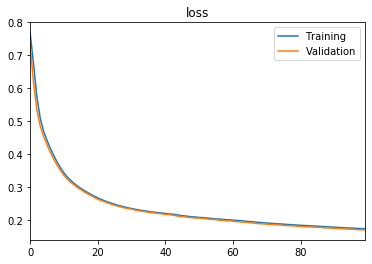

In [83]:
pd.DataFrame(np.array([[np.mean(x) for x in batches_losses], [np.mean(x) for x in val_losses]]).T,
                   columns=['Training', 'Validation']).plot(title="loss")

# Fine tuning of the Encoder for classification

In [118]:
def loss_fun_Encoder(targets, predicted):
    loss = nn.NLLLoss()
    return loss(targets, predicted)

In [93]:
def evaluate(target, predicted):
    true_label_mask = [1 if (np.argmax(x)-target[i]) ==
                       0 else 0 for i, x in enumerate(predicted)]
    nb_prediction = len(true_label_mask)
    true_prediction = sum(true_label_mask)
    false_prediction = nb_prediction-true_prediction
    accuracy = true_prediction/nb_prediction
    return{
        "accuracy": accuracy,
        "nb exemple": len(target),
        "true_prediction": true_prediction,
        "false_prediction": false_prediction,
    }

In [94]:
def train_loop_fun_Encoder(data_loader, model, optimizer, device, scheduler=None):
    model.train()
    t0 = time.time()
    losses = []
    for batch_idx, (data, targets, data_idx) in enumerate(data_loader):
                
        optimizer.zero_grad()
        outputs = model(data)
        
        loss = loss_fun_Encoder(outputs, targets)
        loss.backward()        
        model.float()
        optimizer.step()
        
        if scheduler:
            scheduler.step()
        losses.append(loss.item())
        if batch_idx % 150 == 0:
            print(
                f"___ batch index = {batch_idx} / {len(data_loader)} ({100*batch_idx / len(data_loader):.2f}%), loss = {np.mean(losses[-10:]):.4f}, time = {time.time()-t0:.2f} secondes ___")
            t0 = time.time()
    return losses

In [95]:
def eval_loop_fun_Encoder(data_loader, model, device):
    model.eval()
    fin_targets = []
    fin_outputs = []
    losses = []
    for batch_idx, (data, targets, data_idx) in enumerate(data_loader):

        
        with torch.no_grad():
            outputs = model(data)
            loss = loss_fun_Encoder(outputs, targets)
            losses.append(loss.item())

        fin_targets.append(targets.cpu().detach().numpy())
        fin_outputs.append(outputs.cpu().detach().numpy())
    return np.concatenate(fin_outputs), np.concatenate(fin_targets), losses
#     return np.vstack(fin_outputs), np.vstack(fin_targets), losses

In [96]:
def choose_label_rand(dataset, nb_label, nb_class, train_indices):
    
    idx_label=[]
    nb_label_each_class=nb_label//nb_class
    
    early_stop=False
    
    if nb_label_each_class==0:
        print("The number of classes superior the number of desired labeled data.")
        print("This mean that some class(es) would not have example !")
        nb_label_each_class=1
        early_stop=True
    
    for i in range(nb_class):
        tmp=iter(dataset)
        idx_class=[datapoint[2] for datapoint in tmp if datapoint[1]==i and datapoint[2] in train_indices]
        idx_label.extend(np.random.choice(idx_class, nb_label_each_class, replace=False))
        print(f"Random index has been choosed for the class {i}")
        if early_stop and i+1 == nb_label:
            break
    
    return idx_label
    

In [132]:
TRAIN_BATCH_SIZE=16
EPOCH=500
validation_split = .2
shuffle_dataset = True
random_seed= 42
device="cpu"
nb_training_label=100
nb_class=10
learning_rate = 1e-3
lr=1e-3

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

print('Loading MNIST Dataset...')

dataset = MNIST('./data', transform=img_transform,train=True)# download=True)
mnist_dataset=MNIST_Dataset(dataset)

#train_size = int(0.8 * len(dataset))
#test_size = len(dataset) - train_size
#train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

idx_label=choose_label_rand(mnist_dataset, nb_training_label, nb_class, train_indices)

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(idx_label)
valid_sampler = SubsetRandomSampler(val_indices)

train_data_loader=DataLoader(
    mnist_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    sampler=train_sampler)

valid_data_loader=DataLoader(
    mnist_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    sampler=valid_sampler)


num_training_steps=int(len(dataset) / TRAIN_BATCH_SIZE * EPOCH)

autoencoder_model=torch.load("mnist/AutoEncoder/AutoEncoder_model_epoch100.pt")
model = autoencoder_model.encoder
optimizer=Adam(model.parameters(), lr=lr, weight_decay=1e-5)
# optimizer=AdamW(model.parameters(), lr=lr)
# scheduler = get_linear_schedule_with_warmup(optimizer, 
#                                         num_warmup_steps = 0,
#                                         num_training_steps = num_training_steps)

val_losses=[]
batches_losses=[]
val_acc=[]


for epoch in range(EPOCH):
    t0 = time.time()    
    print(f"\n=============== EPOCH {epoch+1} / {EPOCH} ===============\n")
    batches_losses_tmp=train_loop_fun_Encoder(train_data_loader, model, optimizer, device) #, idx_label)
    epoch_loss=np.mean(batches_losses_tmp)
    print(f"\n*** avg_loss : {epoch_loss:.2f}, time : ~{(time.time()-t0)//60} min ({time.time()-t0:.2f} sec) ***\n")
    t1=time.time()
    output, target, val_losses_tmp=eval_loop_fun_Encoder(valid_data_loader, model, device)
    print(f"==> evaluation : avg_loss = {np.mean(val_losses_tmp):.2f}, time : {time.time()-t1:.2f} sec\n")
    tmp_evaluate=evaluate(target.reshape(-1), output)
    print(f"=====>\t{tmp_evaluate}")
    val_acc.append(tmp_evaluate['accuracy'])
    val_losses.append(val_losses_tmp)
    batches_losses.append(batches_losses_tmp)
    print(f"\t§§ Encoder model has been saved §§")
    torch.save(model, f"mnist/Encoder/Encoder_model_epoch{epoch+1}.pt")

Loading MNIST Dataset...
Random index has been choosed for the class 0
Random index has been choosed for the class 1
Random index has been choosed for the class 2
Random index has been choosed for the class 3
Random index has been choosed for the class 4
Random index has been choosed for the class 5
Random index has been choosed for the class 6
Random index has been choosed for the class 7
Random index has been choosed for the class 8
Random index has been choosed for the class 9

=============== EPOCH 1 / 500 ===============

___ batch index = 0 / 7 (0.00%), loss = -0.1125, time = 0.01 secondes ___

*** avg_loss : -0.12, time : ~0.0 min (0.04 sec) ***

==> evaluation : avg_loss = -0.13, time : 2.13 sec

=====>	{'accuracy': 0.17516666666666666, 'nb exemple': 12000, 'true_prediction': 2102, 'false_prediction': 9898}
	§§ Encoder model has been saved §§

=============== EPOCH 2 / 500 ===============

___ batch index = 0 / 7 (0.00%), loss = -0.1703, time = 0.01 secondes ___

*** avg_loss :

==> evaluation : avg_loss = -0.37, time : 2.26 sec

=====>	{'accuracy': 0.5971666666666666, 'nb exemple': 12000, 'true_prediction': 7166, 'false_prediction': 4834}
	§§ Encoder model has been saved §§

=============== EPOCH 23 / 500 ===============

___ batch index = 0 / 7 (0.00%), loss = -0.5050, time = 0.01 secondes ___

*** avg_loss : -0.43, time : ~0.0 min (0.06 sec) ***

==> evaluation : avg_loss = -0.37, time : 2.28 sec

=====>	{'accuracy': 0.5959166666666667, 'nb exemple': 12000, 'true_prediction': 7151, 'false_prediction': 4849}
	§§ Encoder model has been saved §§

=============== EPOCH 24 / 500 ===============

___ batch index = 0 / 7 (0.00%), loss = -0.5111, time = 0.01 secondes ___

*** avg_loss : -0.47, time : ~0.0 min (0.06 sec) ***

==> evaluation : avg_loss = -0.37, time : 2.28 sec

=====>	{'accuracy': 0.5819166666666666, 'nb exemple': 12000, 'true_prediction': 6983, 'false_prediction': 5017}
	§§ Encoder model has been saved §§

=============== EPOCH 25 / 500 ============

==> evaluation : avg_loss = -0.42, time : 2.26 sec

=====>	{'accuracy': 0.62875, 'nb exemple': 12000, 'true_prediction': 7545, 'false_prediction': 4455}
	§§ Encoder model has been saved §§

=============== EPOCH 45 / 500 ===============

___ batch index = 0 / 7 (0.00%), loss = -0.5619, time = 0.01 secondes ___

*** avg_loss : -0.59, time : ~0.0 min (0.06 sec) ***

==> evaluation : avg_loss = -0.41, time : 2.23 sec

=====>	{'accuracy': 0.6203333333333333, 'nb exemple': 12000, 'true_prediction': 7444, 'false_prediction': 4556}
	§§ Encoder model has been saved §§

=============== EPOCH 46 / 500 ===============

___ batch index = 0 / 7 (0.00%), loss = -0.6863, time = 0.01 secondes ___

*** avg_loss : -0.60, time : ~0.0 min (0.06 sec) ***

==> evaluation : avg_loss = -0.44, time : 2.24 sec

=====>	{'accuracy': 0.633, 'nb exemple': 12000, 'true_prediction': 7596, 'false_prediction': 4404}
	§§ Encoder model has been saved §§

=============== EPOCH 47 / 500 ===============

___ batch index = 0

==> evaluation : avg_loss = -0.45, time : 2.31 sec

=====>	{'accuracy': 0.6290833333333333, 'nb exemple': 12000, 'true_prediction': 7549, 'false_prediction': 4451}
	§§ Encoder model has been saved §§

=============== EPOCH 68 / 500 ===============

___ batch index = 0 / 7 (0.00%), loss = -0.7001, time = 0.01 secondes ___

*** avg_loss : -0.66, time : ~0.0 min (0.06 sec) ***

==> evaluation : avg_loss = -0.42, time : 2.30 sec

=====>	{'accuracy': 0.6119166666666667, 'nb exemple': 12000, 'true_prediction': 7343, 'false_prediction': 4657}
	§§ Encoder model has been saved §§

=============== EPOCH 69 / 500 ===============

___ batch index = 0 / 7 (0.00%), loss = -0.5899, time = 0.01 secondes ___

*** avg_loss : -0.64, time : ~0.0 min (0.06 sec) ***

==> evaluation : avg_loss = -0.43, time : 2.25 sec

=====>	{'accuracy': 0.604, 'nb exemple': 12000, 'true_prediction': 7248, 'false_prediction': 4752}
	§§ Encoder model has been saved §§

=============== EPOCH 70 / 500 ===============

___ batc

==> evaluation : avg_loss = -0.40, time : 2.21 sec

=====>	{'accuracy': 0.54775, 'nb exemple': 12000, 'true_prediction': 6573, 'false_prediction': 5427}
	§§ Encoder model has been saved §§

=============== EPOCH 91 / 500 ===============

___ batch index = 0 / 7 (0.00%), loss = -0.7616, time = 0.01 secondes ___

*** avg_loss : -0.66, time : ~0.0 min (0.06 sec) ***

==> evaluation : avg_loss = -0.44, time : 2.21 sec

=====>	{'accuracy': 0.595, 'nb exemple': 12000, 'true_prediction': 7140, 'false_prediction': 4860}
	§§ Encoder model has been saved §§

=============== EPOCH 92 / 500 ===============

___ batch index = 0 / 7 (0.00%), loss = -0.7038, time = 0.01 secondes ___

*** avg_loss : -0.67, time : ~0.0 min (0.06 sec) ***

==> evaluation : avg_loss = -0.49, time : 2.21 sec

=====>	{'accuracy': 0.6491666666666667, 'nb exemple': 12000, 'true_prediction': 7790, 'false_prediction': 4210}
	§§ Encoder model has been saved §§

=============== EPOCH 93 / 500 ===============

___ batch index = 0

==> evaluation : avg_loss = -0.52, time : 2.25 sec

=====>	{'accuracy': 0.6735833333333333, 'nb exemple': 12000, 'true_prediction': 8083, 'false_prediction': 3917}
	§§ Encoder model has been saved §§

=============== EPOCH 113 / 500 ===============

___ batch index = 0 / 7 (0.00%), loss = -0.8527, time = 0.01 secondes ___

*** avg_loss : -0.75, time : ~0.0 min (0.05 sec) ***

==> evaluation : avg_loss = -0.49, time : 2.21 sec

=====>	{'accuracy': 0.6269166666666667, 'nb exemple': 12000, 'true_prediction': 7523, 'false_prediction': 4477}
	§§ Encoder model has been saved §§

=============== EPOCH 114 / 500 ===============

___ batch index = 0 / 7 (0.00%), loss = -0.8408, time = 0.01 secondes ___

*** avg_loss : -0.75, time : ~0.0 min (0.05 sec) ***

==> evaluation : avg_loss = -0.50, time : 2.22 sec

=====>	{'accuracy': 0.6469166666666667, 'nb exemple': 12000, 'true_prediction': 7763, 'false_prediction': 4237}
	§§ Encoder model has been saved §§

=============== EPOCH 115 / 500 =========

==> evaluation : avg_loss = -0.54, time : 2.25 sec

=====>	{'accuracy': 0.6643333333333333, 'nb exemple': 12000, 'true_prediction': 7972, 'false_prediction': 4028}
	§§ Encoder model has been saved §§

=============== EPOCH 135 / 500 ===============

___ batch index = 0 / 7 (0.00%), loss = -0.7616, time = 0.01 secondes ___

*** avg_loss : -0.77, time : ~0.0 min (0.06 sec) ***

==> evaluation : avg_loss = -0.51, time : 2.25 sec

=====>	{'accuracy': 0.6455833333333333, 'nb exemple': 12000, 'true_prediction': 7747, 'false_prediction': 4253}
	§§ Encoder model has been saved §§

=============== EPOCH 136 / 500 ===============

___ batch index = 0 / 7 (0.00%), loss = -0.8266, time = 0.01 secondes ___

*** avg_loss : -0.73, time : ~0.0 min (0.06 sec) ***

==> evaluation : avg_loss = -0.52, time : 2.33 sec

=====>	{'accuracy': 0.6676666666666666, 'nb exemple': 12000, 'true_prediction': 8012, 'false_prediction': 3988}
	§§ Encoder model has been saved §§

=============== EPOCH 137 / 500 =========

==> evaluation : avg_loss = -0.53, time : 2.24 sec

=====>	{'accuracy': 0.6578333333333334, 'nb exemple': 12000, 'true_prediction': 7894, 'false_prediction': 4106}
	§§ Encoder model has been saved §§

=============== EPOCH 157 / 500 ===============

___ batch index = 0 / 7 (0.00%), loss = -0.7680, time = 0.01 secondes ___

*** avg_loss : -0.73, time : ~0.0 min (0.06 sec) ***

==> evaluation : avg_loss = -0.52, time : 2.25 sec

=====>	{'accuracy': 0.6430833333333333, 'nb exemple': 12000, 'true_prediction': 7717, 'false_prediction': 4283}
	§§ Encoder model has been saved §§

=============== EPOCH 158 / 500 ===============

___ batch index = 0 / 7 (0.00%), loss = -0.8838, time = 0.01 secondes ___

*** avg_loss : -0.80, time : ~0.0 min (0.06 sec) ***

==> evaluation : avg_loss = -0.54, time : 2.34 sec

=====>	{'accuracy': 0.6561666666666667, 'nb exemple': 12000, 'true_prediction': 7874, 'false_prediction': 4126}
	§§ Encoder model has been saved §§

=============== EPOCH 159 / 500 =========

==> evaluation : avg_loss = -0.53, time : 2.30 sec

=====>	{'accuracy': 0.6695, 'nb exemple': 12000, 'true_prediction': 8034, 'false_prediction': 3966}
	§§ Encoder model has been saved §§

=============== EPOCH 179 / 500 ===============

___ batch index = 0 / 7 (0.00%), loss = -0.8658, time = 0.01 secondes ___

*** avg_loss : -0.77, time : ~0.0 min (0.06 sec) ***

==> evaluation : avg_loss = -0.51, time : 2.29 sec

=====>	{'accuracy': 0.661, 'nb exemple': 12000, 'true_prediction': 7932, 'false_prediction': 4068}
	§§ Encoder model has been saved §§

=============== EPOCH 180 / 500 ===============

___ batch index = 0 / 7 (0.00%), loss = -0.8686, time = 0.01 secondes ___

*** avg_loss : -0.79, time : ~0.0 min (0.06 sec) ***

==> evaluation : avg_loss = -0.50, time : 2.31 sec

=====>	{'accuracy': 0.6475833333333333, 'nb exemple': 12000, 'true_prediction': 7771, 'false_prediction': 4229}
	§§ Encoder model has been saved §§

=============== EPOCH 181 / 500 ===============

___ batch index =

==> evaluation : avg_loss = -0.56, time : 2.39 sec

=====>	{'accuracy': 0.6869166666666666, 'nb exemple': 12000, 'true_prediction': 8243, 'false_prediction': 3757}
	§§ Encoder model has been saved §§

=============== EPOCH 201 / 500 ===============

___ batch index = 0 / 7 (0.00%), loss = -0.9262, time = 0.01 secondes ___

*** avg_loss : -0.78, time : ~0.0 min (0.06 sec) ***

==> evaluation : avg_loss = -0.55, time : 2.34 sec

=====>	{'accuracy': 0.6813333333333333, 'nb exemple': 12000, 'true_prediction': 8176, 'false_prediction': 3824}
	§§ Encoder model has been saved §§

=============== EPOCH 202 / 500 ===============

___ batch index = 0 / 7 (0.00%), loss = -0.8553, time = 0.01 secondes ___

*** avg_loss : -0.81, time : ~0.0 min (0.06 sec) ***

==> evaluation : avg_loss = -0.54, time : 2.35 sec

=====>	{'accuracy': 0.6798333333333333, 'nb exemple': 12000, 'true_prediction': 8158, 'false_prediction': 3842}
	§§ Encoder model has been saved §§

=============== EPOCH 203 / 500 =========

==> evaluation : avg_loss = -0.55, time : 2.38 sec

=====>	{'accuracy': 0.6886666666666666, 'nb exemple': 12000, 'true_prediction': 8264, 'false_prediction': 3736}
	§§ Encoder model has been saved §§

=============== EPOCH 223 / 500 ===============

___ batch index = 0 / 7 (0.00%), loss = -0.8337, time = 0.01 secondes ___

*** avg_loss : -0.82, time : ~0.0 min (0.06 sec) ***

==> evaluation : avg_loss = -0.55, time : 2.36 sec

=====>	{'accuracy': 0.672, 'nb exemple': 12000, 'true_prediction': 8064, 'false_prediction': 3936}
	§§ Encoder model has been saved §§

=============== EPOCH 224 / 500 ===============

___ batch index = 0 / 7 (0.00%), loss = -0.9199, time = 0.01 secondes ___

*** avg_loss : -0.85, time : ~0.0 min (0.06 sec) ***

==> evaluation : avg_loss = -0.54, time : 2.38 sec

=====>	{'accuracy': 0.6844166666666667, 'nb exemple': 12000, 'true_prediction': 8213, 'false_prediction': 3787}
	§§ Encoder model has been saved §§

=============== EPOCH 225 / 500 ===============

___ b

==> evaluation : avg_loss = -0.48, time : 2.29 sec

=====>	{'accuracy': 0.6211666666666666, 'nb exemple': 12000, 'true_prediction': 7454, 'false_prediction': 4546}
	§§ Encoder model has been saved §§

=============== EPOCH 246 / 500 ===============

___ batch index = 0 / 7 (0.00%), loss = -0.8416, time = 0.01 secondes ___

*** avg_loss : -0.85, time : ~0.0 min (0.06 sec) ***

==> evaluation : avg_loss = -0.46, time : 2.26 sec

=====>	{'accuracy': 0.5980833333333333, 'nb exemple': 12000, 'true_prediction': 7177, 'false_prediction': 4823}
	§§ Encoder model has been saved §§

=============== EPOCH 247 / 500 ===============

___ batch index = 0 / 7 (0.00%), loss = -0.8621, time = 0.01 secondes ___

*** avg_loss : -0.78, time : ~0.0 min (0.06 sec) ***

==> evaluation : avg_loss = -0.49, time : 2.26 sec

=====>	{'accuracy': 0.62425, 'nb exemple': 12000, 'true_prediction': 7491, 'false_prediction': 4509}
	§§ Encoder model has been saved §§

=============== EPOCH 248 / 500 ===============

___

==> evaluation : avg_loss = -0.56, time : 2.50 sec

=====>	{'accuracy': 0.6766666666666666, 'nb exemple': 12000, 'true_prediction': 8120, 'false_prediction': 3880}
	§§ Encoder model has been saved §§

=============== EPOCH 268 / 500 ===============

___ batch index = 0 / 7 (0.00%), loss = -0.9317, time = 0.01 secondes ___

*** avg_loss : -0.82, time : ~0.0 min (0.07 sec) ***

==> evaluation : avg_loss = -0.57, time : 2.41 sec

=====>	{'accuracy': 0.6855, 'nb exemple': 12000, 'true_prediction': 8226, 'false_prediction': 3774}
	§§ Encoder model has been saved §§

=============== EPOCH 269 / 500 ===============

___ batch index = 0 / 7 (0.00%), loss = -0.9402, time = 0.01 secondes ___

*** avg_loss : -0.86, time : ~0.0 min (0.07 sec) ***

==> evaluation : avg_loss = -0.57, time : 2.49 sec

=====>	{'accuracy': 0.6821666666666667, 'nb exemple': 12000, 'true_prediction': 8186, 'false_prediction': 3814}
	§§ Encoder model has been saved §§

=============== EPOCH 270 / 500 ===============

___ 

==> evaluation : avg_loss = -0.55, time : 2.37 sec

=====>	{'accuracy': 0.6911666666666667, 'nb exemple': 12000, 'true_prediction': 8294, 'false_prediction': 3706}
	§§ Encoder model has been saved §§

=============== EPOCH 290 / 500 ===============

___ batch index = 0 / 7 (0.00%), loss = -0.8765, time = 0.01 secondes ___

*** avg_loss : -0.86, time : ~0.0 min (0.08 sec) ***

==> evaluation : avg_loss = -0.55, time : 2.39 sec

=====>	{'accuracy': 0.6725, 'nb exemple': 12000, 'true_prediction': 8070, 'false_prediction': 3930}
	§§ Encoder model has been saved §§

=============== EPOCH 291 / 500 ===============

___ batch index = 0 / 7 (0.00%), loss = -0.7862, time = 0.01 secondes ___

*** avg_loss : -0.84, time : ~0.0 min (0.06 sec) ***

==> evaluation : avg_loss = -0.55, time : 2.32 sec

=====>	{'accuracy': 0.67575, 'nb exemple': 12000, 'true_prediction': 8109, 'false_prediction': 3891}
	§§ Encoder model has been saved §§

=============== EPOCH 292 / 500 ===============

___ batch index

==> evaluation : avg_loss = -0.56, time : 2.26 sec

=====>	{'accuracy': 0.689, 'nb exemple': 12000, 'true_prediction': 8268, 'false_prediction': 3732}
	§§ Encoder model has been saved §§

=============== EPOCH 312 / 500 ===============

___ batch index = 0 / 7 (0.00%), loss = -0.9080, time = 0.01 secondes ___

*** avg_loss : -0.89, time : ~0.0 min (0.04 sec) ***

==> evaluation : avg_loss = -0.56, time : 2.22 sec

=====>	{'accuracy': 0.6923333333333334, 'nb exemple': 12000, 'true_prediction': 8308, 'false_prediction': 3692}
	§§ Encoder model has been saved §§

=============== EPOCH 313 / 500 ===============

___ batch index = 0 / 7 (0.00%), loss = -0.9027, time = 0.01 secondes ___

*** avg_loss : -0.86, time : ~0.0 min (0.05 sec) ***

==> evaluation : avg_loss = -0.56, time : 2.21 sec

=====>	{'accuracy': 0.6963333333333334, 'nb exemple': 12000, 'true_prediction': 8356, 'false_prediction': 3644}
	§§ Encoder model has been saved §§

=============== EPOCH 314 / 500 ===============

___ b

==> evaluation : avg_loss = -0.58, time : 2.29 sec

=====>	{'accuracy': 0.705, 'nb exemple': 12000, 'true_prediction': 8460, 'false_prediction': 3540}
	§§ Encoder model has been saved §§

=============== EPOCH 334 / 500 ===============

___ batch index = 0 / 7 (0.00%), loss = -0.8285, time = 0.01 secondes ___

*** avg_loss : -0.83, time : ~0.0 min (0.06 sec) ***

==> evaluation : avg_loss = -0.59, time : 2.31 sec

=====>	{'accuracy': 0.7038333333333333, 'nb exemple': 12000, 'true_prediction': 8446, 'false_prediction': 3554}
	§§ Encoder model has been saved §§

=============== EPOCH 335 / 500 ===============

___ batch index = 0 / 7 (0.00%), loss = -0.9242, time = 0.01 secondes ___

*** avg_loss : -0.84, time : ~0.0 min (0.06 sec) ***

==> evaluation : avg_loss = -0.58, time : 2.31 sec

=====>	{'accuracy': 0.6888333333333333, 'nb exemple': 12000, 'true_prediction': 8266, 'false_prediction': 3734}
	§§ Encoder model has been saved §§

=============== EPOCH 336 / 500 ===============

___ b

==> evaluation : avg_loss = -0.54, time : 2.70 sec

=====>	{'accuracy': 0.6633333333333333, 'nb exemple': 12000, 'true_prediction': 7960, 'false_prediction': 4040}
	§§ Encoder model has been saved §§

=============== EPOCH 356 / 500 ===============

___ batch index = 0 / 7 (0.00%), loss = -0.8664, time = 0.01 secondes ___

*** avg_loss : -0.80, time : ~0.0 min (0.07 sec) ***

==> evaluation : avg_loss = -0.57, time : 2.48 sec

=====>	{'accuracy': 0.6808333333333333, 'nb exemple': 12000, 'true_prediction': 8170, 'false_prediction': 3830}
	§§ Encoder model has been saved §§

=============== EPOCH 357 / 500 ===============

___ batch index = 0 / 7 (0.00%), loss = -0.8604, time = 0.01 secondes ___

*** avg_loss : -0.83, time : ~0.0 min (0.06 sec) ***

==> evaluation : avg_loss = -0.57, time : 2.45 sec

=====>	{'accuracy': 0.67975, 'nb exemple': 12000, 'true_prediction': 8157, 'false_prediction': 3843}
	§§ Encoder model has been saved §§

=============== EPOCH 358 / 500 ===============

___

==> evaluation : avg_loss = -0.56, time : 2.33 sec

=====>	{'accuracy': 0.6725833333333333, 'nb exemple': 12000, 'true_prediction': 8071, 'false_prediction': 3929}
	§§ Encoder model has been saved §§

=============== EPOCH 378 / 500 ===============

___ batch index = 0 / 7 (0.00%), loss = -0.9701, time = 0.01 secondes ___

*** avg_loss : -0.87, time : ~0.0 min (0.06 sec) ***

==> evaluation : avg_loss = -0.56, time : 2.33 sec

=====>	{'accuracy': 0.6833333333333333, 'nb exemple': 12000, 'true_prediction': 8200, 'false_prediction': 3800}
	§§ Encoder model has been saved §§

=============== EPOCH 379 / 500 ===============

___ batch index = 0 / 7 (0.00%), loss = -0.9494, time = 0.01 secondes ___

*** avg_loss : -0.92, time : ~0.0 min (0.06 sec) ***

==> evaluation : avg_loss = -0.58, time : 2.35 sec

=====>	{'accuracy': 0.6895833333333333, 'nb exemple': 12000, 'true_prediction': 8275, 'false_prediction': 3725}
	§§ Encoder model has been saved §§

=============== EPOCH 380 / 500 =========

==> evaluation : avg_loss = -0.59, time : 2.32 sec

=====>	{'accuracy': 0.6898333333333333, 'nb exemple': 12000, 'true_prediction': 8278, 'false_prediction': 3722}
	§§ Encoder model has been saved §§

=============== EPOCH 400 / 500 ===============

___ batch index = 0 / 7 (0.00%), loss = -0.9273, time = 0.01 secondes ___

*** avg_loss : -0.87, time : ~0.0 min (0.06 sec) ***

==> evaluation : avg_loss = -0.56, time : 2.30 sec

=====>	{'accuracy': 0.6563333333333333, 'nb exemple': 12000, 'true_prediction': 7876, 'false_prediction': 4124}
	§§ Encoder model has been saved §§

=============== EPOCH 401 / 500 ===============

___ batch index = 0 / 7 (0.00%), loss = -0.8654, time = 0.01 secondes ___

*** avg_loss : -0.83, time : ~0.0 min (0.06 sec) ***

==> evaluation : avg_loss = -0.57, time : 2.33 sec

=====>	{'accuracy': 0.6550833333333334, 'nb exemple': 12000, 'true_prediction': 7861, 'false_prediction': 4139}
	§§ Encoder model has been saved §§

=============== EPOCH 402 / 500 =========

==> evaluation : avg_loss = -0.60, time : 2.32 sec

=====>	{'accuracy': 0.7008333333333333, 'nb exemple': 12000, 'true_prediction': 8410, 'false_prediction': 3590}
	§§ Encoder model has been saved §§

=============== EPOCH 422 / 500 ===============

___ batch index = 0 / 7 (0.00%), loss = -0.8891, time = 0.01 secondes ___

*** avg_loss : -0.88, time : ~0.0 min (0.06 sec) ***

==> evaluation : avg_loss = -0.59, time : 2.31 sec

=====>	{'accuracy': 0.6949166666666666, 'nb exemple': 12000, 'true_prediction': 8339, 'false_prediction': 3661}
	§§ Encoder model has been saved §§

=============== EPOCH 423 / 500 ===============

___ batch index = 0 / 7 (0.00%), loss = -0.9379, time = 0.01 secondes ___

*** avg_loss : -0.90, time : ~0.0 min (0.06 sec) ***

==> evaluation : avg_loss = -0.54, time : 2.33 sec

=====>	{'accuracy': 0.6543333333333333, 'nb exemple': 12000, 'true_prediction': 7852, 'false_prediction': 4148}
	§§ Encoder model has been saved §§

=============== EPOCH 424 / 500 =========

==> evaluation : avg_loss = -0.57, time : 2.30 sec

=====>	{'accuracy': 0.6663333333333333, 'nb exemple': 12000, 'true_prediction': 7996, 'false_prediction': 4004}
	§§ Encoder model has been saved §§

=============== EPOCH 444 / 500 ===============

___ batch index = 0 / 7 (0.00%), loss = -0.9118, time = 0.01 secondes ___

*** avg_loss : -0.87, time : ~0.0 min (0.06 sec) ***

==> evaluation : avg_loss = -0.57, time : 2.30 sec

=====>	{'accuracy': 0.6786666666666666, 'nb exemple': 12000, 'true_prediction': 8144, 'false_prediction': 3856}
	§§ Encoder model has been saved §§

=============== EPOCH 445 / 500 ===============

___ batch index = 0 / 7 (0.00%), loss = -0.9645, time = 0.01 secondes ___

*** avg_loss : -0.87, time : ~0.0 min (0.06 sec) ***

==> evaluation : avg_loss = -0.53, time : 2.30 sec

=====>	{'accuracy': 0.6463333333333333, 'nb exemple': 12000, 'true_prediction': 7756, 'false_prediction': 4244}
	§§ Encoder model has been saved §§

=============== EPOCH 446 / 500 =========

==> evaluation : avg_loss = -0.58, time : 2.26 sec

=====>	{'accuracy': 0.68225, 'nb exemple': 12000, 'true_prediction': 8187, 'false_prediction': 3813}
	§§ Encoder model has been saved §§

=============== EPOCH 466 / 500 ===============

___ batch index = 0 / 7 (0.00%), loss = -0.9608, time = 0.01 secondes ___

*** avg_loss : -0.90, time : ~0.0 min (0.06 sec) ***

==> evaluation : avg_loss = -0.58, time : 2.30 sec

=====>	{'accuracy': 0.6901666666666667, 'nb exemple': 12000, 'true_prediction': 8282, 'false_prediction': 3718}
	§§ Encoder model has been saved §§

=============== EPOCH 467 / 500 ===============

___ batch index = 0 / 7 (0.00%), loss = -0.8828, time = 0.01 secondes ___

*** avg_loss : -0.88, time : ~0.0 min (0.06 sec) ***

==> evaluation : avg_loss = -0.58, time : 2.29 sec

=====>	{'accuracy': 0.6890833333333334, 'nb exemple': 12000, 'true_prediction': 8269, 'false_prediction': 3731}
	§§ Encoder model has been saved §§

=============== EPOCH 468 / 500 ===============

___

==> evaluation : avg_loss = -0.56, time : 2.33 sec

=====>	{'accuracy': 0.6644166666666667, 'nb exemple': 12000, 'true_prediction': 7973, 'false_prediction': 4027}
	§§ Encoder model has been saved §§

=============== EPOCH 488 / 500 ===============

___ batch index = 0 / 7 (0.00%), loss = -0.8445, time = 0.01 secondes ___

*** avg_loss : -0.85, time : ~0.0 min (0.06 sec) ***

==> evaluation : avg_loss = -0.58, time : 2.33 sec

=====>	{'accuracy': 0.6780833333333334, 'nb exemple': 12000, 'true_prediction': 8137, 'false_prediction': 3863}
	§§ Encoder model has been saved §§

=============== EPOCH 489 / 500 ===============

___ batch index = 0 / 7 (0.00%), loss = -0.9169, time = 0.01 secondes ___

*** avg_loss : -0.90, time : ~0.0 min (0.06 sec) ***

==> evaluation : avg_loss = -0.58, time : 2.33 sec

=====>	{'accuracy': 0.68275, 'nb exemple': 12000, 'true_prediction': 8193, 'false_prediction': 3807}
	§§ Encoder model has been saved §§

=============== EPOCH 490 / 500 ===============

___

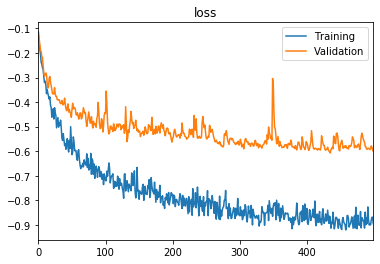

In [148]:
pd.DataFrame(np.array([[np.mean(x) for x in batches_losses], [np.mean(x) for x in val_losses]]).T,
                   columns=['Training', 'Validation']).plot(title="loss")

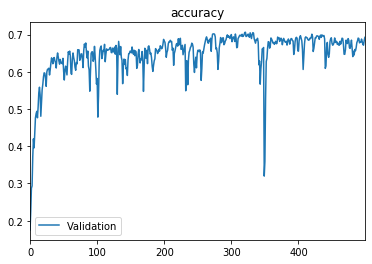

In [149]:
pd.DataFrame(np.array(val_acc).T,
                   columns=['Validation']).plot(title="accuracy")

In [152]:
print(f"maximal Accuracy of {round(max(val_acc),2)} on the epoch {np.argmax(val_acc)+1}")

maximal Accuracy of 0.71 on the epoch 322


In [154]:
# test on MNIST

model_test=torch.load("./mnist/Encoder/Encoder_model_epoch322.pt")
test_losses=[]
test_acc=[]
t1=time.time()
test_dataset = MNIST('./data', transform=img_transform,train=False)# download=True)
test_mnist_dataset=MNIST_Dataset(test_dataset)
test_data_loader=DataLoader(
    test_mnist_dataset,
    batch_size=TRAIN_BATCH_SIZE)
output, target, test_losses_tmp=eval_loop_fun_Encoder(test_data_loader, model_test, device)
print(f"==> evaluation : avg_loss = {np.mean(test_losses_tmp):.2f}, time : {time.time()-t1:.2f} sec\n")
test_evaluate=evaluate(target.reshape(-1), output)
print(f"=====>\t{test_evaluate}")
test_acc.append(test_evaluate['accuracy'])
test_losses.append(test_losses_tmp)
    

==> evaluation : avg_loss = -0.59, time : 1.90 sec

=====>	{'accuracy': 0.7194, 'nb exemple': 10000, 'true_prediction': 7194, 'false_prediction': 2806}


In [137]:
model

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten()
  (7): Linear(in_features=32, out_features=32, bias=True)
  (8): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ReLU(inplace=True)
  (10): Linear(in_features=32, out_features=16, bias=True)
  (11): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU(inplace=True)
  (13): Linear(in_features=16, out_features=10, bias=True)
  (14): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (15): Softmax(dim=1)
)